# Google Colab 한글 폰트 설치

In [3]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [4]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
from pgmpy.factors.discrete import JointProbabilityDistribution as JPD
import sympy

scipy.__version__

'1.15.2'

- 테스트

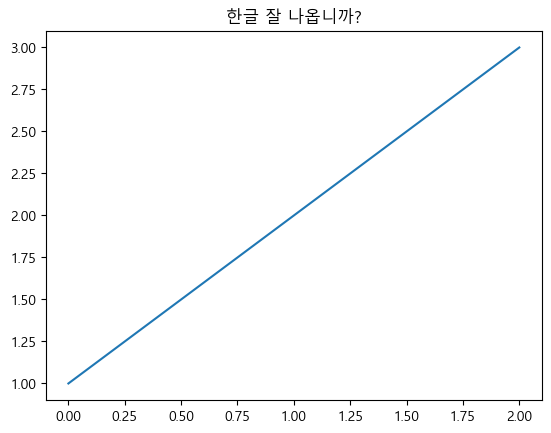

In [5]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# VAR 모델 (벡터작기회귀)

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
# from tqdm import tqdm_notebook
from tqdm.auto import tqdm  # 일반 CLI용 progress bar
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## GDP 데이터
- realgdp : 실질 GDP (목표 변수 또는 내생 변수)
- realcons : 실질 개인 소비 지출
- realinv : 실질 국내 총 민간 투자
- realgovt : 실질 연방 소비 지출 및 투자
- realdpi : 실질 민간 가처분 소득
- cpi : 분기 말 소비자물가지수
- m1 : M1 명목 통화량
- tbilrate : 3개월 만기 국채의 분기별 월평균 금리
- unemp : 실업률
- pop : 분기 말 총 인구
- infl : 인플레이션율
- realint : 실질 이자율

In [7]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


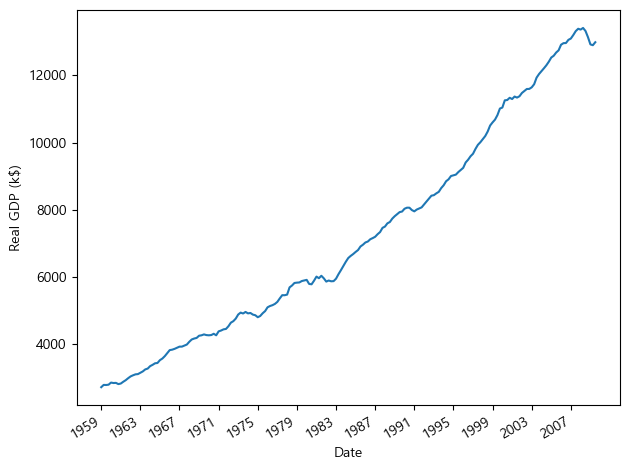

In [8]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

## 각 변수별 시각화
- 실질소비(realcons) : 사람들이 얼마나 많은 돈을 소비하는지 나타냄
- 실질 가처분 소득(realdpi) : 얼마나 많은 돈을 쓸 수 있는지를 나타냄
- 양방향 관계 예시
  + 가설1 : 가처분 소득이 많을수록 소비가 많다
  + 가설2 : 소비가 많다는 것은 더 많은 가처분 소득이 있다.
- 위 관계를 VAR 모델로 포착 가능

## 정상성 확인

In [9]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.9860253519546847
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.5499123380509598
p-value: 0.9976992503412904


In [10]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673008
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


## 모델 만들기
- 많은 VAR(p) 모델을 적합하고 가장 낮은 AIC를 가진 모델을 선택하는 함수

In [11]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:

    results = []

    for i in tqdm(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [12]:
endog = macro_econ_data[['realdpi', 'realcons']]

# X와 Y값 모두 정상성 시계열이어야 함
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070082
1,5,3123.708523
2,6,3126.855594
3,4,3129.194050
4,2,3130.091668
5,7,3133.395903
6,1,3134.333343
7,8,3137.149015
8,9,3140.367176
9,10,3147.838974


## 그레인저 인과관계 테스트
- 귀무가설 : 한 변수가 다른 변수를 예측하는데 도움이 되지 않는다.
- 대립가설 : 한 변수가 다른 변수를 예측하는데 도움이 된다.

In [13]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


## 잔차 분석
- 두 그래프 모두, 잔차가 백색소음에 가까움


In [14]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Fri, 16 May 2025   BIC                           3175.559
Time:                             17:40:08   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

- 잔차의 히스토그램, Q-Q 도식, 상관도 확인

### variable=0, realdpi

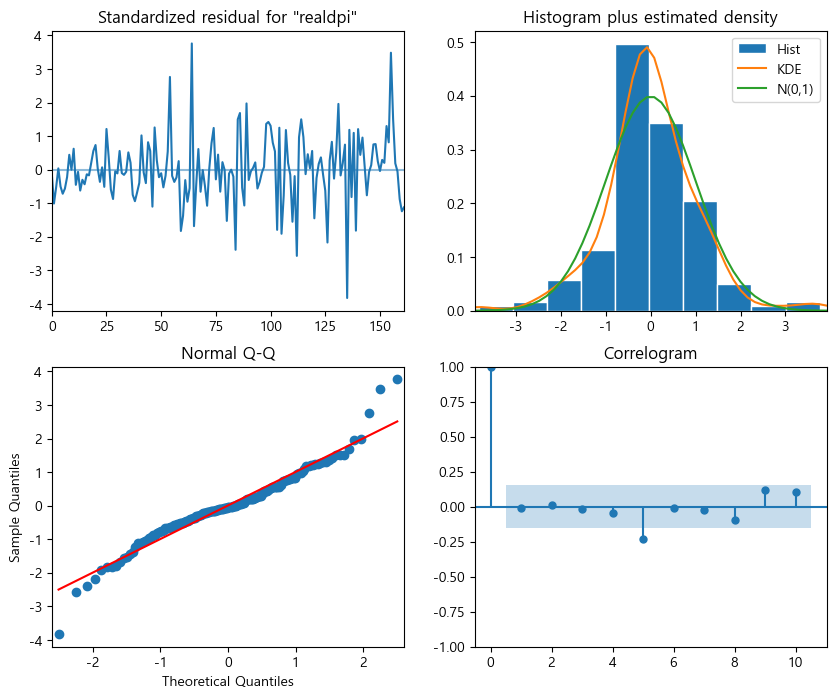

In [15]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

### variable=1, realcons

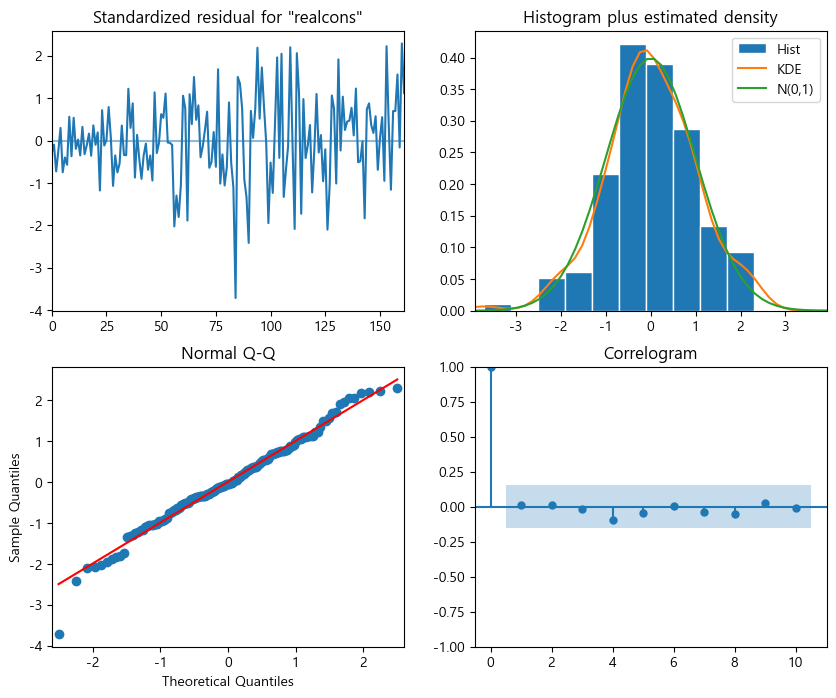

In [16]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

### 융-박스 테스트

In [17]:
realgdp_residuals = best_model_fit.resid['realdpi']
acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.011604,0.914218
2,0.029334,0.985440
3,0.075744,0.994580
4,0.377886,0.984247
5,9.142614,0.103509
6,9.165446,0.164485
7,9.270206,0.233834
8,10.811714,0.212598
9,13.318272,0.148726
10,15.287590,0.121923


In [18]:
realcons_residuals = best_model_fit.resid['realcons']
acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.023915,0.877102
2,0.068595,0.966284
3,0.068672,0.995311
4,0.235637,0.993581
5,0.377737,0.995921
6,0.787339,0.992409
7,1.015325,0.994578
8,2.150628,0.976042
9,2.437293,0.982523
10,2.442957,0.991681


## 모형 예측
- realdpi와 realcons에 대한 예측 출력
- 예측 결과를 포함하는 두 개의 목록 반환

In [19]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []

        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)

        return realdpi_pred_VAR, realcons_pred_VAR

    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []

        for i in range(train_len, total_len, window):

            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

- 한 번에 미래의 시간 단계 네 개를 예측하고자 하므로 윈도우는 4이며, 이는 1년과 동일

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

- 누적 합계 사용해 적분하여 데이터의 원래 규모로 되돌리기

In [21]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.223941,7354.326414
164,8053.4,7501.3,7897.188067,7430.258604
165,8135.9,7571.8,7960.561951,7496.633927
166,8222.3,7645.9,8014.755840,7556.621362
167,8234.6,7713.5,8080.701771,7631.003670
168,8296.5,7744.3,8142.391535,7692.851650
169,8273.7,7773.5,8200.122470,7753.870920
170,8484.5,7807.7,8259.361053,7812.538596
171,8385.5,7930.0,8264.385027,7864.639209
172,8611.6,7957.3,8320.857399,7895.063964


- 테스트 집합의 실제값, VAR(3) 모델의 예측, 베이스라인 모델의 예측이 test에 저장

In [22]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.223941,7354.326414,7716.0,7199.9
164,8053.4,7501.3,7897.188067,7430.258604,7716.0,7199.9
165,8135.9,7571.8,7960.561951,7496.633927,7716.0,7199.9
166,8222.3,7645.9,8014.755840,7556.621362,7716.0,7199.9
167,8234.6,7713.5,8080.701771,7631.003670,8135.9,7571.8
168,8296.5,7744.3,8142.391535,7692.851650,8135.9,7571.8
169,8273.7,7773.5,8200.122470,7753.870920,8135.9,7571.8
170,8484.5,7807.7,8259.361053,7812.538596,8135.9,7571.8
171,8385.5,7930.0,8264.385027,7864.639209,8273.7,7773.5
172,8611.6,7957.3,8320.857399,7895.063964,8273.7,7773.5


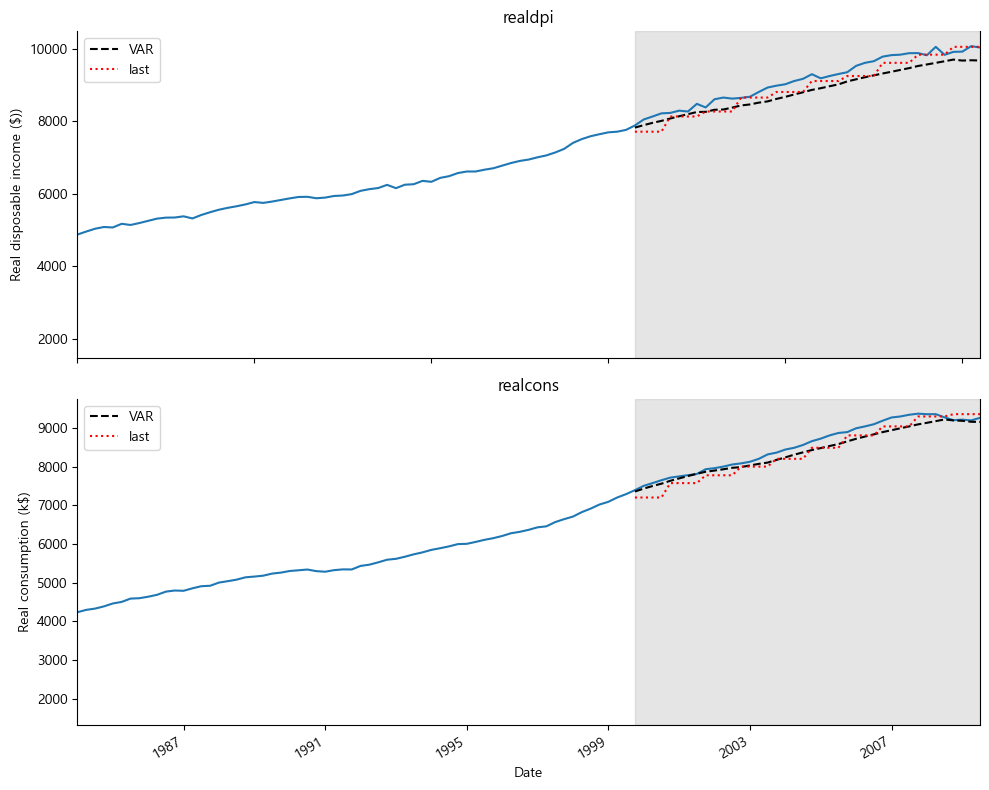

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모형 평가

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

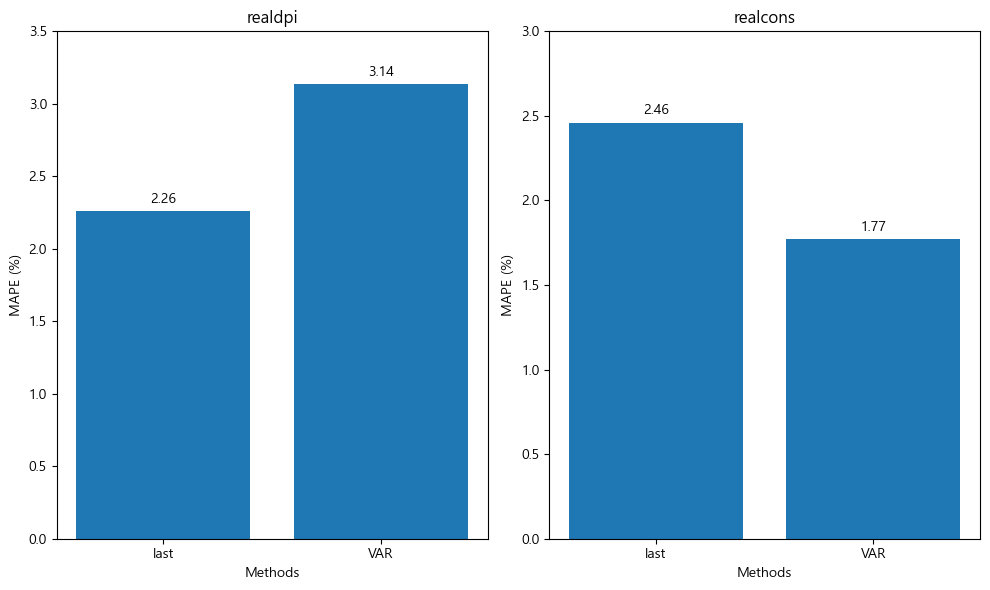

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()